# Automate generating of the HoopForce using Python

In [1]:
#load in the path to the Plaxis 
import imp
import sys
sys.path.append(r'C:\Users\dazhong.li\OneDrive\05Research\00Codes\01Python\pythonlib\plaxisremote')
from plaxisremote import Output
import plaxisremote as plxrmt
import os
import numpy as np
import pandas as pd
#$from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image
%matplotlib inline

In [2]:
port_o = 10001
port_I = 10000
plx_o = Output(port_o)
plx_i = plxrmt.Input(port_I)
path = r'\\HKGNTS22\geo\Actual Job\211036\11-00 Calculations\11-02 Seawall Design\Post 2016 GI\02 Sections\CH 2150 P_E2 K053\01 Plaxis\UD Study'
os.chdir(path)
g_o = plx_o.g_o
# plx_o.open_file(os.path.join(path,'CH4150_C099_Udr_Rev01.p2dx'))
#plx_o.open_file(r'C:\Users\dazhong.li\Desktop\New folder (4)\MCC_AxSC_UPMW_r02.p2dx')

In [3]:
Phase = plx_o.get_phase_by_name('Phase_4')
x = np.array(g_o.getresults(Phase, g_o.ResultTypes.Soil.X, "node"))
y = np.array(g_o.getresults(Phase, g_o.ResultTypes.Soil.Y, "node"))
C = np.array(g_o.getresults(Phase, g_o.ResultTypes.Soil.C, "node"))
SigyyE = np.array(g_o.getresults(Phase, g_o.ResultTypes.Soil.SigyyE, "node"))
MeanEffStress = np.array(g_o.getresults(Phase, g_o.ResultTypes.Soil.MeanEffStress, "node"))
df = pd.DataFrame(dict(x=[],y=[],C=[],sigma_y_e =[],p_e=[]))
df.x=x; df.y=y; df.C=C; df.sigma_y_e = SigyyE; df.p_e = MeanEffStress

# define the line for the interpolations

In [4]:
p1 = np.array([0.49, -14.0])
p2 = np.array([0.49, -32.0])
#f = interp2d(np.array(df.x), np.array(df.y), np.array(df.C), kind='linear')

In [5]:
x = np.zeros((20,2))
x[:,0] = np.linspace(p1[0],p2[0],20)
x[:,1] = np.linspace(p1[1],p2[1],20)

In [6]:
x[:,0]

array([0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49,
       0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49])

In [7]:
Phase = plx_o.get_phase_by_name('Phase_22')
#MeanEffStress = np.array(g_o.getsingleresult(Phase, g_o.ResultTypes.Soil.MeanEffStress,(-14.2,0)))

In [3]:
def get_slice_result(Phase,result_type,coord):
    #import pdb; pdb.set_trace()
    temp = []
    for i in np.arange(coord.shape[0]):
        temp.append((g_o.getsingleresult(Phase,result_type,(coord[i,0],coord[i,1]))))
    sliced_result = np.array(temp)
    sliced_result = sliced_result.astype(np.float)
    return sliced_result
    #print(np.array(g_o.getsingleresult(Phase, g_o.ResultTypes.Soil.MeanEffStress, (x,y))))

In [9]:
Phase = plx_o.get_phase_by_name('Phase_22')

In [10]:
get_slice_result (Phase,g_o.ResultTypes.Soil.C,x)

array([ 11.5 ,  11.5 ,  13.75, ..., -47.5 , -47.5 , -50.  ])

# let's setup a page and do the plotting

In [63]:
location = 'CH4725 & CH4900 Area1'
p1 = np.array([-24, -13.0])
p2 = np.array([-24, -31.0])
def generate_stress_ratio_plot(phase,p1,p2):
    Phase = plx_o.get_phase_by_name(phase)
    n = 20
    x = np.zeros((n,2))
    x[:,0] = np.linspace(p1[0],p2[0],n)
    x[:,1] = np.linspace(p1[1],p2[1],n)
    #C = get_slice_result (Phase,g_o.ResultTypes.Soil.C,x)
    sigma_y_e = get_slice_result (Phase,g_o.ResultTypes.Soil.SigyyE,x)
    p = get_slice_result (Phase,g_o.ResultTypes.Soil.MeanEffStress,x)
    C = get_slice_result (Phase,g_o.ResultTypes.Soil.C,x)

    fig = plt.figure(figsize=(16.53,11.69))
    ax1 = fig.add_subplot(121)
    ax1.set_ylabel('Elevation(mPD)')
    ax1.set_title(r"Effective Stress $\sigma^\prime_v$ or $p^\prime$")
    ax2 = fig.add_subplot(122)
    ax2.set_ylabel('Elevation(mPD)')
    ax2.set_title(r"Strength Ratio  $c_u/\sigma^\prime_v$ or $c_u/p^\prime$")
    ax1.plot(sigma_y_e *-1,x[:,1],marker='^',label='$\sigma^\prime_{v}$',c='k')
    ax1.plot(C ,x[:,1],marker='^',label='$c_u$',c='g')
    ax1.plot(p *-1,x[:,1],marker='^',label='$p^\prime$',c='b')
    ax1.xaxis.set_ticks(np.arange(0,400,50))
    ax1.yaxis.set_ticks(np.arange(0,-30,-5))
    ax1.set_xlabel('Pressure (kPa)')

    #----------plot ratio
    ax2.plot(C/sigma_y_e *-1,x[:,1],marker='^',label=r'$\frac{C_u}{\sigma^\prime_{v}}$',c='k')
#     ax2.plot(C/p *-1,x[:,1],marker='^',label=r'$\frac{C_u}{\sigma^\prime_{v}}}$',c='b')
    ax2.plot(C/p *-1,x[:,1],marker='^',label=r'$\frac{C_u}{{p^\prime}}$',c='b')
    ax2.yaxis.set_ticks(np.arange(0,-30,-5))
    ax2.xaxis.set_ticks(np.arange(0,1,0.1))
    ax2.set_xlabel('Stress Ratio')
    ax2.axvline(0.2,c='b',linestyle ='--')
    ax2.axvline(0.3,c='b',linestyle ='--',label='Expected Range')
    ax2.legend()
    ax2.grid()
    ax1.legend()
    ax1.grid()
    fig.suptitle(location)
    fig.savefig(location +'.pdf')
    #

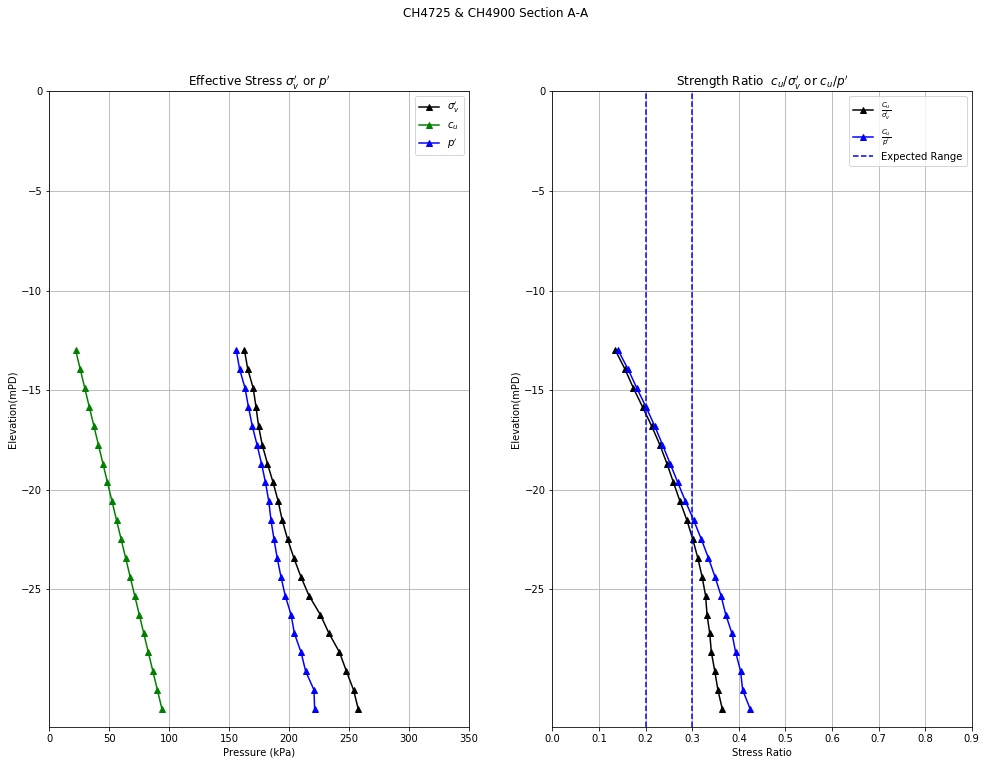

In [75]:
location = "CH4725 & CH4900 Section A-A"
p1 = np.array([-24, -13.0])
p2 = np.array([-24, -31.0])
generate_stress_ratio_plot('Phase_26',p1,p2)

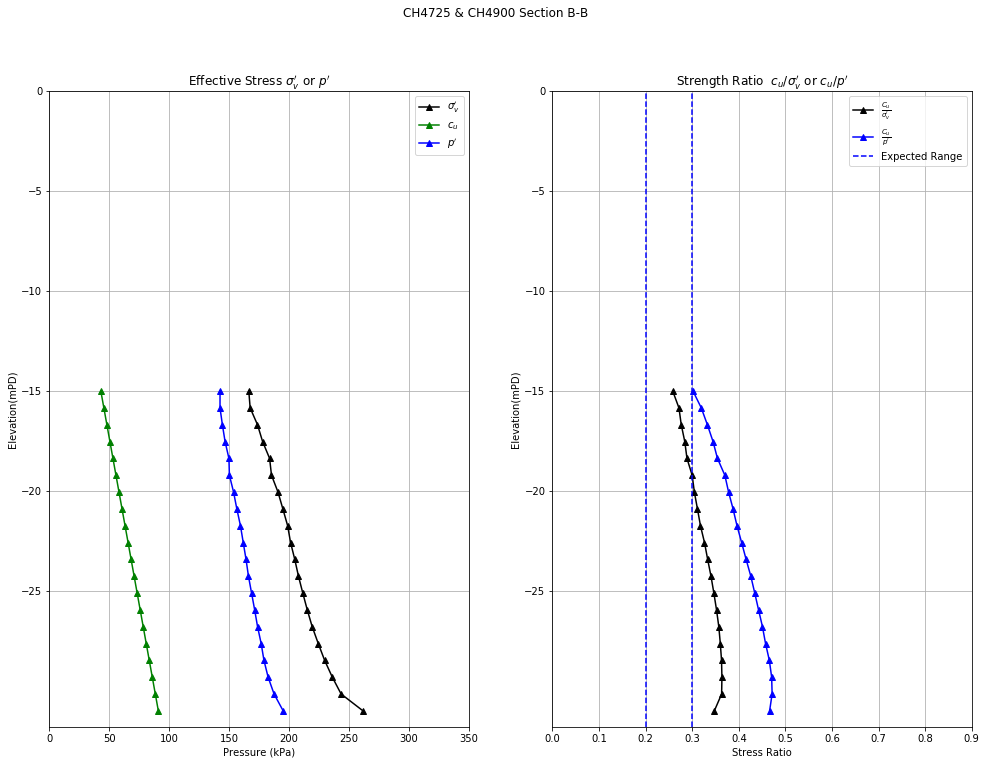

In [76]:
location = "CH4725 & CH4900 Section B-B"
p1 = np.array([5, -15.0])
p2 = np.array([5, -31.0])
generate_stress_ratio_plot('Phase_26',p1,p2)

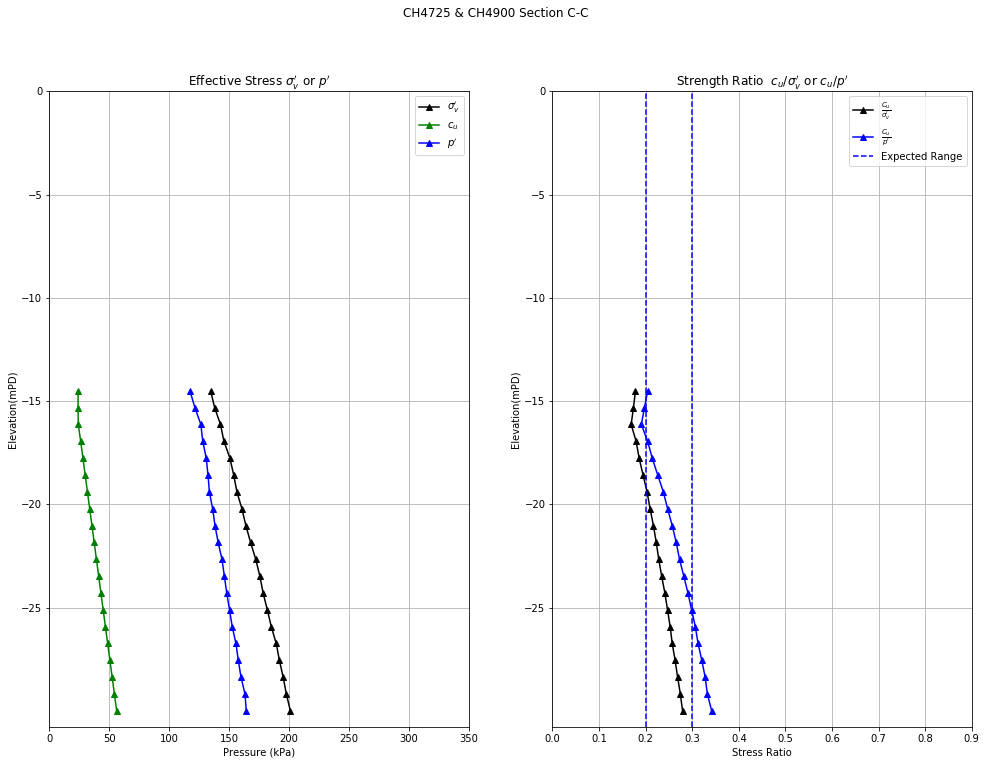

In [77]:
location = "CH4725 & CH4900 Section C-C"
p1 = np.array([21, -14.5])
p2 = np.array([21, -30.0])
generate_stress_ratio_plot('Phase_26',p1,p2)

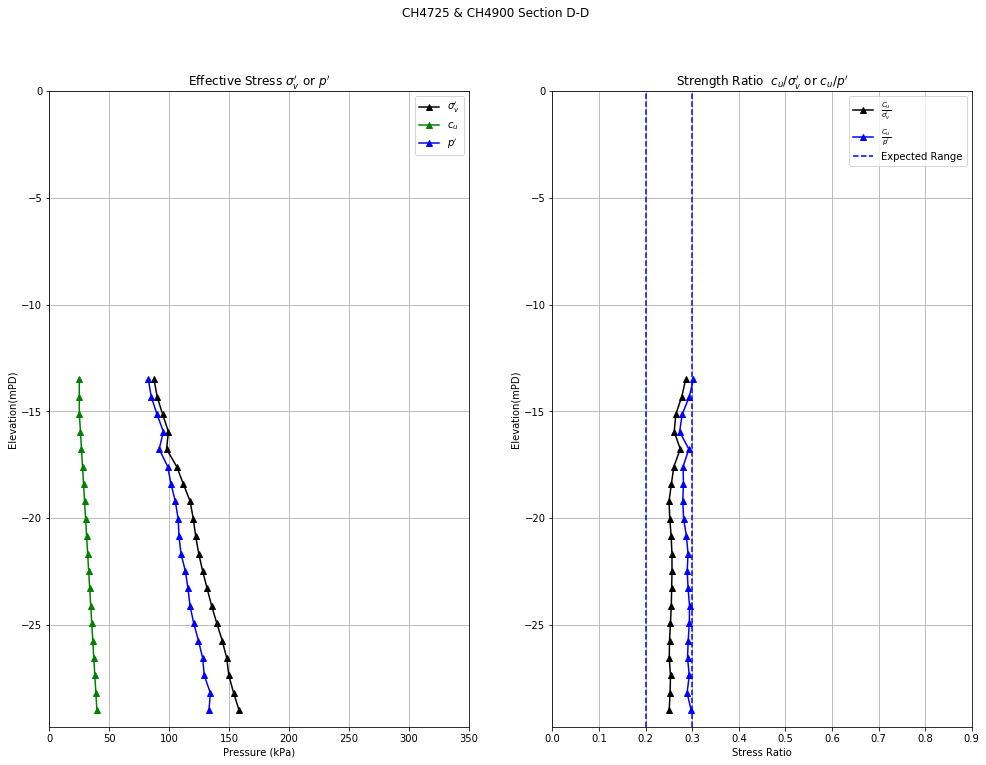

In [78]:
location = "CH4725 & CH4900 Section D-D"
p1 = np.array([42, -13.5])
p2 = np.array([42, -29.0])
generate_stress_ratio_plot('Phase_26',p1,p2)

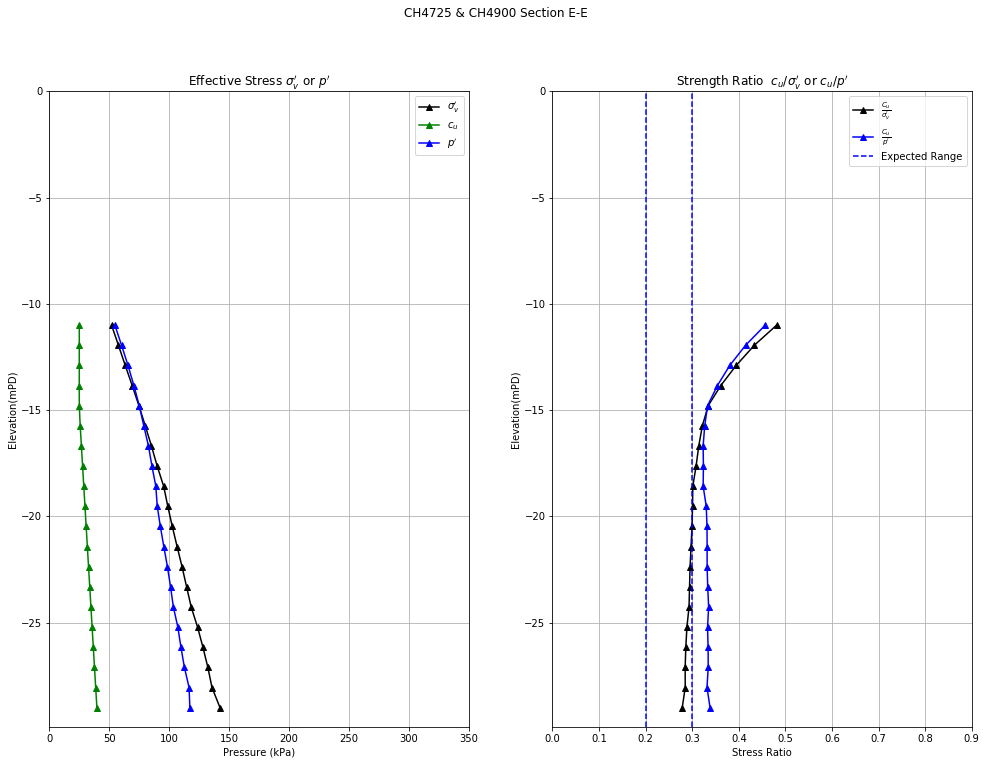

In [79]:
location = "CH4725 & CH4900 Section E-E"
p1 = np.array([54, -11.0])
p2 = np.array([54, -29.0])
generate_stress_ratio_plot('Phase_26',p1,p2)

In [80]:
os.getcwd()

'\\\\HKGNTS22\\geo\\Actual Job\\211036\\11-00 Calculations\\11-02 Seawall Design\\Post 2016 GI\\02 Sections\\CH 2150 P_E2 K053\\01 Plaxis\\UD Study'

In [97]:
import re
for x in plx_i.g_i.Points[:]:
    printre.(x.BoundingBox)

TypeError: expected string or bytes-like object

In [111]:
y = plx_i.g_i.Points[0]

In [103]:
type(y.BoundingBox[:])

str

In [143]:
y = np.array(re.findall(r'\d+\.\d+',str(y)))

In [144]:
from shapely.geometry import Point

In [145]:
x = plx_i.g_i.Soils[0]

In [146]:
y = x.Parent

In [147]:
print(y.Length)

0
